In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import nnde
from mpl_toolkits.mplot3d import Axes3D
np.seterr(all='raise')
import pixiedust

Pixiedust database opened successfully


# Solving ODEs

## Example 1

$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$

With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [2]:
Xe1 = np.arange(0,1,0.1) + 1e-6
Xe1 = Xe1.reshape((Xe1.shape[0],1,1))

The trial solution for this case is $\Psi(x)=1 + x N(x)$.
The first function below is the function $A(x)=1$
and the second function is the function $B(x)=x$.

In [70]:
def example1_initial_value(point):
  return 1

In [4]:
def example1_boundary_vanishing(point):
  return point

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [5]:
def example1_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * (1 + point * N) 
      - point ** 3 - 2 * point - point ** 2 *(1 + 3 * point ** 2)/(1 + point + point ** 3)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [6]:
def example1_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [7]:
def example1_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * (
      point * db_DN[0, 0, m] + db_N[0, 0, m] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * db_N[0, 0, m])
  return db

In [8]:
def example1_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (
        point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dH_N[0, 0, m, p])
  return dH

In [9]:
def example1_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (
        point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dV_N[0, 0, m, p])
  return dV

### Defining the trial solution with an apropiate network

In [10]:
example1_trial_solution = nnde.TrialSolution(loss_function=example1_loss_function,
                                        loss_function_single_point=example1_loss_function_single_point,
                                        bias_change=example1_bias_change,
                                        hidden_weights_change=example1_hidden_weights_change,
                                        visible_weights_change=example1_visible_weights_change,
                                        boundary_condition_value_function=example1_initial_value,
                                        boundary_vanishing_function=example1_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-1, momentum=1e-1)

### Training

In [11]:
example1_trial_solution.train(Xe1, 1000)

Epoch: 1 Loss function: 0.5810167539089898
Epoch: 2 Loss function: 1.1550880053493606
Epoch: 3 Loss function: 0.6084020778210559
Epoch: 4 Loss function: 0.36533219922062626
Epoch: 5 Loss function: 0.36509124484759103
Epoch: 6 Loss function: 0.21680868578536364
Epoch: 7 Loss function: 0.20144007902218924
Epoch: 8 Loss function: 0.12141074473035134
Epoch: 9 Loss function: 0.11838981981712947
Epoch: 10 Loss function: 0.05105624339676252
Epoch: 11 Loss function: 0.043529696029288655
Epoch: 12 Loss function: 0.035215277469575326
Epoch: 13 Loss function: 0.016370616977371858
Epoch: 14 Loss function: 0.01551361809833257
Epoch: 15 Loss function: 0.02066955182925137
Epoch: 16 Loss function: 0.015740671821448116
Epoch: 17 Loss function: 0.00981369881150138
Epoch: 18 Loss function: 0.012142073782828016
Epoch: 19 Loss function: 0.008022666042362125
Epoch: 20 Loss function: 0.07762825249241173
Epoch: 21 Loss function: 0.009099509329659285
Epoch: 22 Loss function: 0.007883757849492634
Epoch: 23 Loss

Epoch: 266 Loss function: 0.0020298823614169743
Epoch: 267 Loss function: 0.002067587212547177
Epoch: 268 Loss function: 0.0025749120416831152
Epoch: 269 Loss function: 0.0026554594558640386
Epoch: 270 Loss function: 0.0022580133317372628
Epoch: 271 Loss function: 0.0019958832855372192
Epoch: 272 Loss function: 0.0019404532072297652
Epoch: 273 Loss function: 0.0019780269534053745
Epoch: 274 Loss function: 0.00216912715140842
Epoch: 275 Loss function: 0.002767507757333206
Epoch: 276 Loss function: 0.002375216201582525
Epoch: 277 Loss function: 0.003041528931261224
Epoch: 278 Loss function: 0.0020138991145471573
Epoch: 279 Loss function: 0.0022610547205598797
Epoch: 280 Loss function: 0.0018999300010495938
Epoch: 281 Loss function: 0.0019652670010010535
Epoch: 282 Loss function: 0.0024828595788980415
Epoch: 283 Loss function: 0.002544373115921107
Epoch: 284 Loss function: 0.0018855282336720475
Epoch: 285 Loss function: 0.00258457491382965
Epoch: 286 Loss function: 0.0031050514841352984
E

Epoch: 442 Loss function: 0.0016752220610076602
Epoch: 443 Loss function: 0.0014557902334216503
Epoch: 444 Loss function: 0.0014874019188098227
Epoch: 445 Loss function: 0.001453721730584851
Epoch: 446 Loss function: 0.0014283225803139764
Epoch: 447 Loss function: 0.0014080887701639604
Epoch: 448 Loss function: 0.0014361351619484363
Epoch: 449 Loss function: 0.0016313877804685092
Epoch: 450 Loss function: 0.001412737827311034
Epoch: 451 Loss function: 0.0014096232343423264
Epoch: 452 Loss function: 0.0015265686621296997
Epoch: 453 Loss function: 0.0014118234213627333
Epoch: 454 Loss function: 0.0014194475397952802
Epoch: 455 Loss function: 0.0014093756453885818
Epoch: 456 Loss function: 0.001480234549073198
Epoch: 457 Loss function: 0.0014655148698509894
Epoch: 458 Loss function: 0.0014481103980129486
Epoch: 459 Loss function: 0.0013859463539367858
Epoch: 460 Loss function: 0.001383496588268567
Epoch: 461 Loss function: 0.0014032815712806364
Epoch: 462 Loss function: 0.0014196860475117

Epoch: 647 Loss function: 0.0011538715892509671
Epoch: 648 Loss function: 0.001154721545843128
Epoch: 649 Loss function: 0.001160649823747339
Epoch: 650 Loss function: 0.0011795720455185523
Epoch: 651 Loss function: 0.0012350494088215873
Epoch: 652 Loss function: 0.0012374333051709207
Epoch: 653 Loss function: 0.0011532556744982235
Epoch: 654 Loss function: 0.0011481469654624095
Epoch: 655 Loss function: 0.0012104768804077908
Epoch: 656 Loss function: 0.0011709306776565424
Epoch: 657 Loss function: 0.0011644199883805485
Epoch: 658 Loss function: 0.0011474734189012446
Epoch: 659 Loss function: 0.0011627802212918878
Epoch: 660 Loss function: 0.0011606695814655732
Epoch: 661 Loss function: 0.0011549576460206355
Epoch: 662 Loss function: 0.0011546666495012262
Epoch: 663 Loss function: 0.0011676398153598604
Epoch: 664 Loss function: 0.0011473899260284882
Epoch: 665 Loss function: 0.001165444381247727
Epoch: 666 Loss function: 0.0011476649554777335
Epoch: 667 Loss function: 0.001140918767810

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

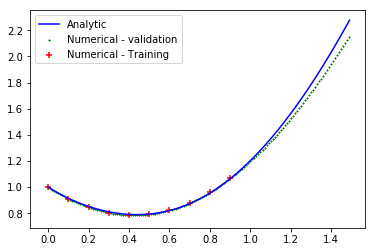

In [12]:
Xe1plot = np.arange(0,1.5, 0.01)
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0], 1, 1))
Ye1 = np.array([example1_trial_solution.predict(Xe1plot[i]) for i in range(Xe1plot.shape[0])]).reshape((Xe1plot.shape[0],))
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0],))
plt.scatter(Xe1plot, Ye1, c='g', label='Numerical - validation', marker='x', s=1)
Ye12 = np.array([np.exp(-0.5*Xe1plot[i]**2)/(1+Xe1plot[i]+Xe1plot[i]**3) + Xe1plot[i]**2 for i in range(Xe1plot.shape[0])])
plt.plot(Xe1plot, Ye12, c='b', label='Analytic')
Ye1sol = np.array([example1_trial_solution.predict(Xe1[i]) for i in range(Xe1.shape[0])]).reshape((Xe1.shape[0],))
plt.scatter(Xe1.reshape((Xe1.shape[0],)), Ye1sol, c='r', label='Numerical - Training', marker='+', s=30)
plt.legend()
plt.show()

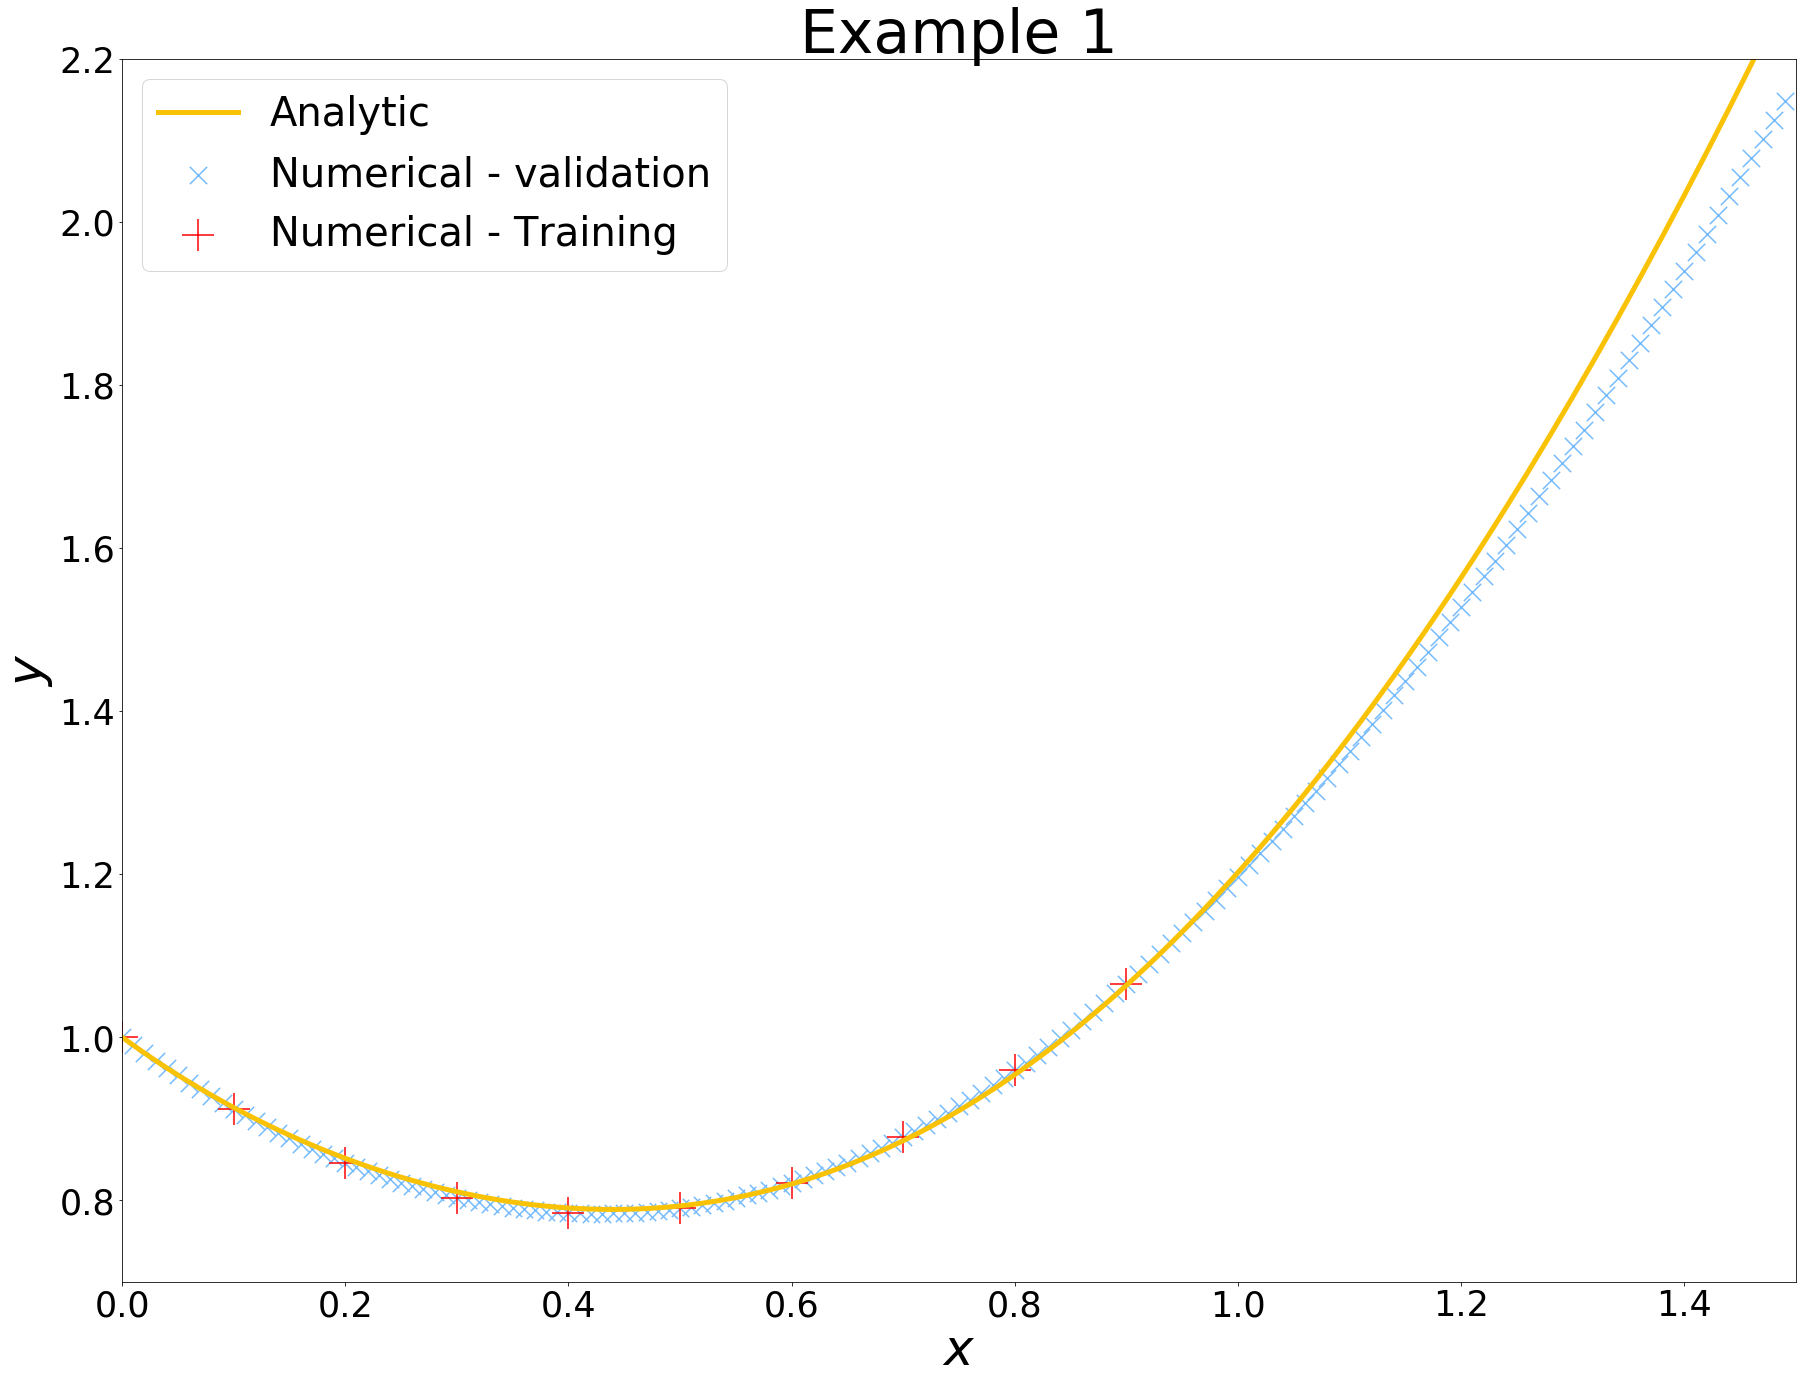

In [58]:
plt.clf()
plt.scatter(Xe1plot, Ye1, c='xkcd:sky blue', label='Numerical - validation', marker='x', s=300)
plt.scatter(Xe1.reshape((Xe1.shape[0],)), Ye1sol, c='r', label='Numerical - Training', marker='+', s=1000)
plt.plot(Xe1plot, Ye12, c='xkcd:goldenrod', label='Analytic', linewidth=5)
plt.xlabel(r'$x$', fontsize='50')
plt.ylabel(r'$y$', fontsize='50')
plt.xlim((0,1.5))
plt.ylim((0.7,2.2))
# plt.axis('equal')
plt.legend(fontsize='40')
plt.title('Example 1', fontsize='60')
plt.gcf().set_size_inches(30, 22.5)
plt.tick_params(axis='both', which='major', labelsize=35)
plt.savefig('plots/example1.jpg')
plt.show()

## Example 2

$\frac{d}{dx}\Psi+\frac{1}{5}\Psi=\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$ and domain $x\in[0,2]$

In [13]:
Xe2 = np.arange(0,2,0.2) + 1e-6
Xe2 = Xe2.reshape((Xe2.shape[0],1,1))

The trial solution for this case is $\Psi(x)=x N(x)$.
The first function below is the function $A(x)=0$
and the second function is the function $B(x)=x$.

In [14]:
def example2_initial_value(point):
  return 0

In [15]:
def example2_boundary_vanishing(point):
  return point

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [16]:
def example2_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + 0.2 * point * N - np.exp(-0.2*point)*np.cos(point)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [17]:
def example2_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [18]:
def example2_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( point * db_DN[0, 0, m] + db_N[0, 0, m] + 0.2 * point * db_N[0, 0, m])
  return db

In [19]:
def example2_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * ( point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + 0.2 * point * dH_N[0, 0, m, p])
  return dH

In [20]:
def example2_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + 0.2 * point * dV_N[0, 0, m, p])
  return dV

### Defining the trial solution with an apropiate network

In [21]:
example2_trial_solution = nnde.TrialSolution(loss_function=example2_loss_function,
                                        loss_function_single_point=example2_loss_function_single_point,
                                        bias_change=example2_bias_change,
                                        hidden_weights_change=example2_hidden_weights_change,
                                        visible_weights_change=example2_visible_weights_change,
                                        boundary_condition_value_function=example2_initial_value,
                                        boundary_vanishing_function=example2_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-1, momentum=1e-1)

### Training

In [22]:
example2_trial_solution.train(Xe2, 1000)

Epoch: 1 Loss function: 0.10778283766909762
Epoch: 2 Loss function: 0.06816959030858091
Epoch: 3 Loss function: 0.016356758183023637
Epoch: 4 Loss function: 0.0144245120541465
Epoch: 5 Loss function: 0.004211157185963176
Epoch: 6 Loss function: 0.0022362383724010967
Epoch: 7 Loss function: 0.006822736386330349
Epoch: 8 Loss function: 0.0017543946898365902
Epoch: 9 Loss function: 0.0016054892551547715
Epoch: 10 Loss function: 0.001628839857582733
Epoch: 11 Loss function: 0.0025713667578266294
Epoch: 12 Loss function: 0.0015616730893109132
Epoch: 13 Loss function: 0.0015443282867343645
Epoch: 14 Loss function: 0.0028784300219583006
Epoch: 15 Loss function: 0.0057313612813214565
Epoch: 16 Loss function: 0.0016756292486166213
Epoch: 17 Loss function: 0.0010441154855547594
Epoch: 18 Loss function: 0.0017389320747252495
Epoch: 19 Loss function: 0.001370547962152417
Epoch: 20 Loss function: 0.0012939574232850412
Epoch: 21 Loss function: 0.002861412600071011
Epoch: 22 Loss function: 0.00132012

Epoch: 175 Loss function: 0.0001682122334941469
Epoch: 176 Loss function: 0.00017176100385668722
Epoch: 177 Loss function: 0.00018275966924392994
Epoch: 178 Loss function: 0.0002205714166304006
Epoch: 179 Loss function: 0.0001689572949579385
Epoch: 180 Loss function: 0.0001983817273385975
Epoch: 181 Loss function: 0.0003180851266520058
Epoch: 182 Loss function: 0.00020447362679841893
Epoch: 183 Loss function: 0.0001722239125533881
Epoch: 184 Loss function: 0.0002556315526947416
Epoch: 185 Loss function: 0.0002218500557678025
Epoch: 186 Loss function: 0.00017370046126518324
Epoch: 187 Loss function: 0.0002482116712389696
Epoch: 188 Loss function: 0.00018751205752146616
Epoch: 189 Loss function: 0.00018697133633500967
Epoch: 190 Loss function: 0.00016356534947474584
Epoch: 191 Loss function: 0.00016307259469695254
Epoch: 192 Loss function: 0.0002000265398955093
Epoch: 193 Loss function: 0.00016281387635395716
Epoch: 194 Loss function: 0.00018499410822819034
Epoch: 195 Loss function: 0.00

Epoch: 373 Loss function: 0.00016922149474877783
Epoch: 374 Loss function: 0.00014681153962975757
Epoch: 375 Loss function: 0.0001467613723058293
Epoch: 376 Loss function: 0.0001681475814376298
Epoch: 377 Loss function: 0.0001739538028289881
Epoch: 378 Loss function: 0.00015155492489328382
Epoch: 379 Loss function: 0.00014660082271162364
Epoch: 380 Loss function: 0.00016291159554720724
Epoch: 381 Loss function: 0.00015396189420598949
Epoch: 382 Loss function: 0.00014939526197607286
Epoch: 383 Loss function: 0.00018244066299021182
Epoch: 384 Loss function: 0.00014644452666467522
Epoch: 385 Loss function: 0.000155092546076843
Epoch: 386 Loss function: 0.00014710729519809657
Epoch: 387 Loss function: 0.00015006787865217233
Epoch: 388 Loss function: 0.00014794540820112781
Epoch: 389 Loss function: 0.00014599628467559545
Epoch: 390 Loss function: 0.00014634272984502392
Epoch: 391 Loss function: 0.00014882850351392271
Epoch: 392 Loss function: 0.0001459788442925918
Epoch: 393 Loss function: 

Epoch: 705 Loss function: 0.00013833863927193257
Epoch: 706 Loss function: 0.0001397022243606735
Epoch: 707 Loss function: 0.00013830837176649367
Epoch: 708 Loss function: 0.00013859001958224851
Epoch: 709 Loss function: 0.00014213167122741145
Epoch: 710 Loss function: 0.0001382590688840921
Epoch: 711 Loss function: 0.00013879913822385957
Epoch: 712 Loss function: 0.00013863896595780282
Epoch: 713 Loss function: 0.00013827961802381672
Epoch: 714 Loss function: 0.00013825747067664016
Epoch: 715 Loss function: 0.00013961703628428453
Epoch: 716 Loss function: 0.0001387660264128852
Epoch: 717 Loss function: 0.0001387848021074472
Epoch: 718 Loss function: 0.00013874693570626055
Epoch: 719 Loss function: 0.00014085382671591085
Epoch: 720 Loss function: 0.00013836825832248137
Epoch: 721 Loss function: 0.0001408134578706064
Epoch: 722 Loss function: 0.00013808301411331457
Epoch: 723 Loss function: 0.00014113400795878658
Epoch: 724 Loss function: 0.00013914633018610398
Epoch: 725 Loss function:

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

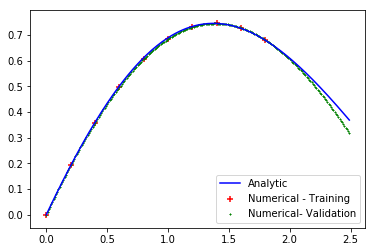

In [23]:
Ye2sol = np.array([example2_trial_solution.predict(Xe2[i]) for i in range(Xe2.shape[0])]).reshape((Xe2.shape[0],))
plt.scatter(Xe2.reshape((Xe2.shape[0],)), Ye2sol, c='r', label='Numerical - Training', marker='+', s=30)
Xe2plot = np.arange(0,2.5, 0.01)
Xe2plot = Xe2plot.reshape((Xe2plot.shape[0], 1, 1))
Ye2 = np.array([example2_trial_solution.predict(Xe2plot[i]) for i in range(Xe2plot.shape[0])]).reshape((Xe2plot.shape[0],))
Xe2plot = Xe2plot.reshape((Xe2plot.shape[0],))
Ye22 = np.array([np.exp(-0.2*Xe2plot[i]) * np.sin(Xe2plot[i]) for i in range(Xe2plot.shape[0])])
plt.scatter(Xe2plot, Ye2, c='g', label='Numerical- Validation', marker='x', s=1)
plt.plot(Xe2plot, Ye22, c='b', label='Analytic')
plt.legend()
plt.show()

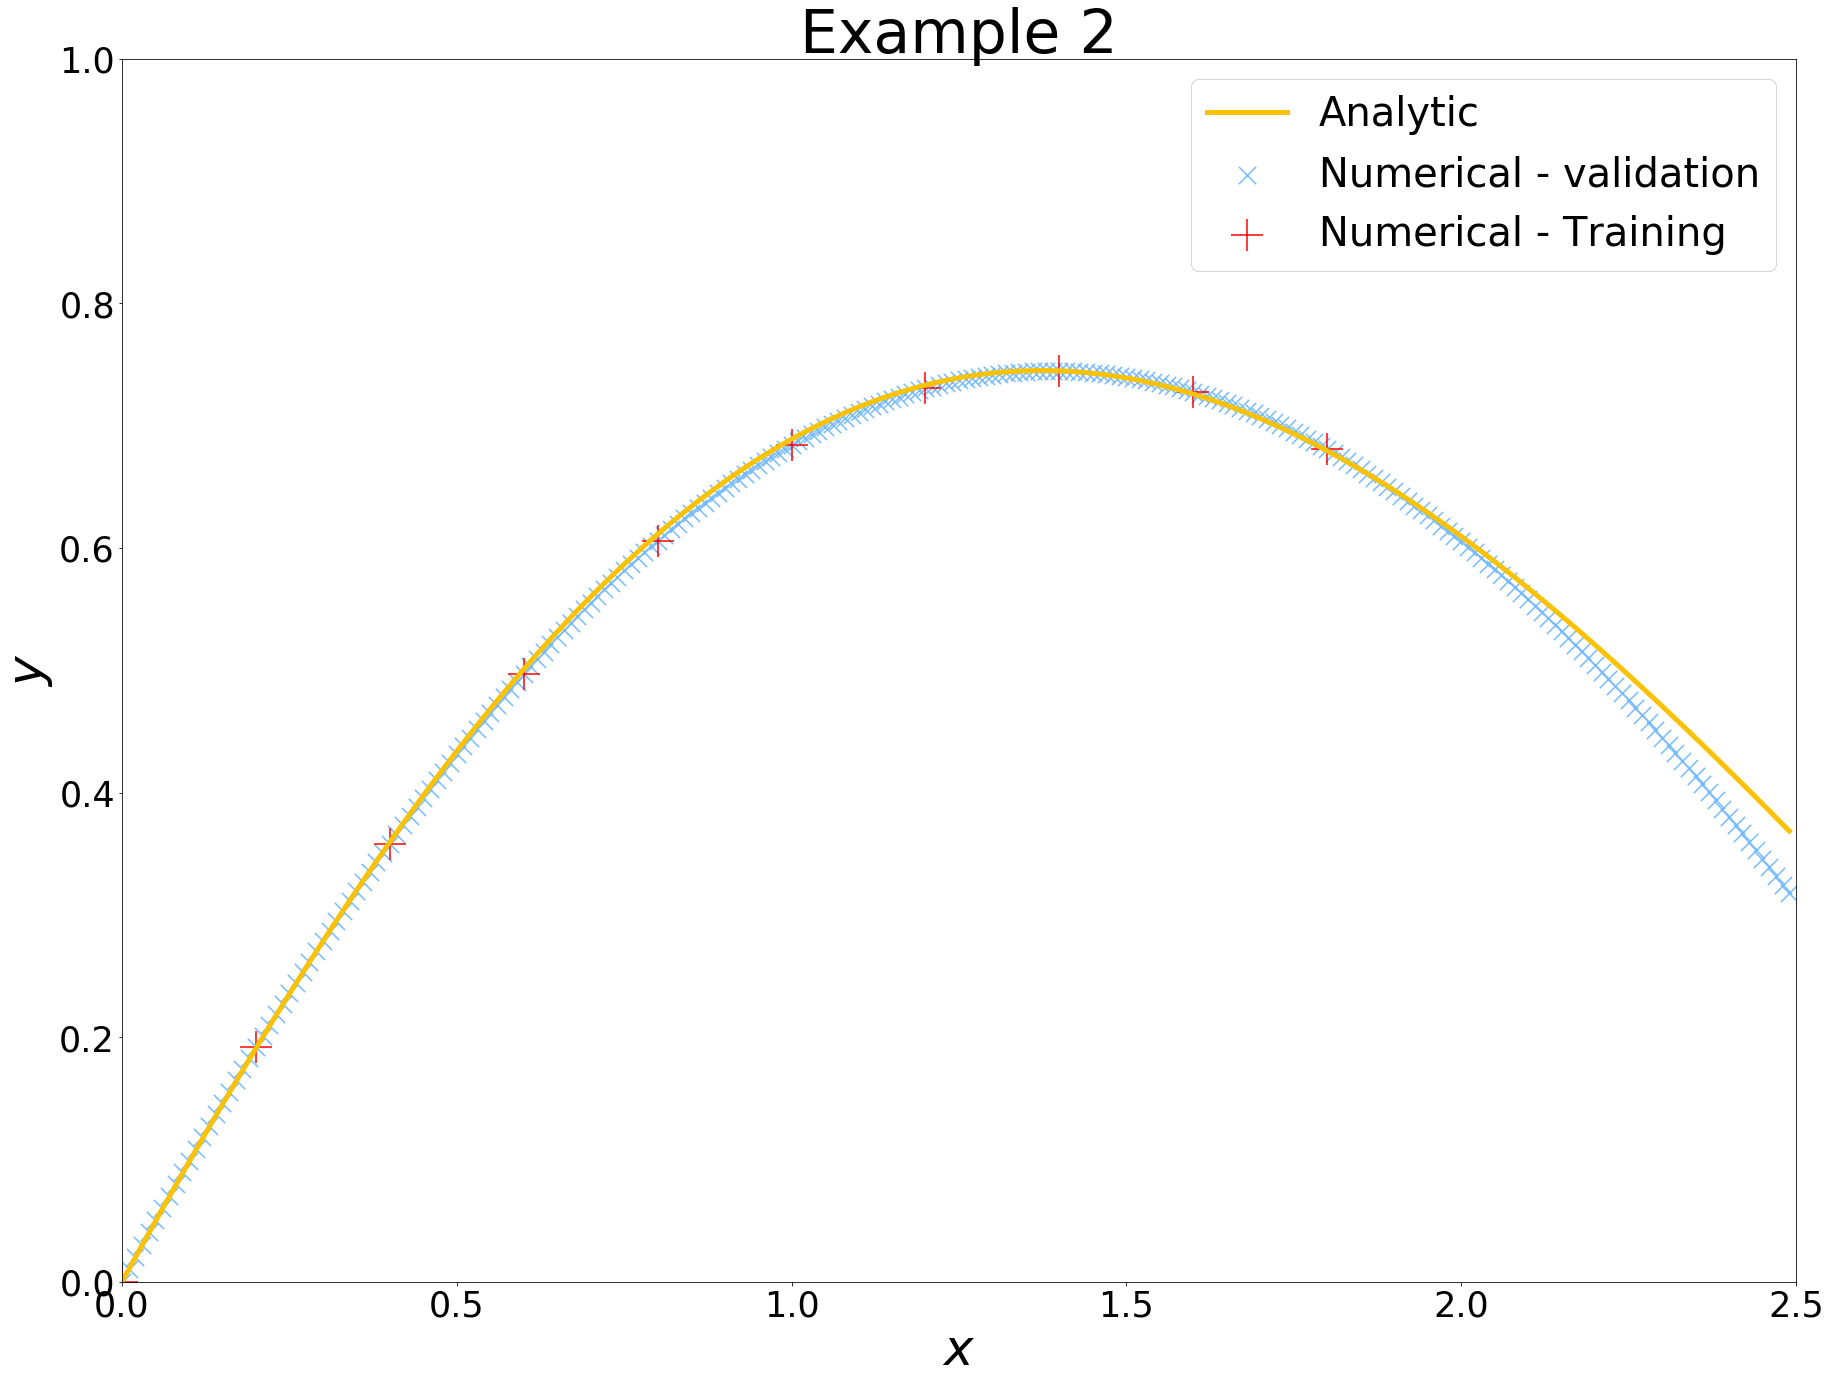

In [69]:
plt.clf()
plt.scatter(Xe2plot, Ye2, c='xkcd:sky blue', label='Numerical - validation', marker='x', s=300)
plt.scatter(Xe2.reshape((Xe2.shape[0],)), Ye2sol, c='r', label='Numerical - Training', marker='+', s=1000)
plt.plot(Xe2plot, Ye22, c='xkcd:goldenrod', label='Analytic', linewidth=5)
plt.xlabel(r'$x$', fontsize='50')
plt.ylabel(r'$y$', fontsize='50')
plt.xlim((0,2.5))
plt.ylim((0.,1))
# plt.axis('equal')
plt.legend(fontsize='40')
plt.title('Example 2', fontsize='60')
plt.gcf().set_size_inches(30, 22.5)
plt.tick_params(axis='both', which='major', labelsize=35)
plt.savefig('plots/example2.jpg')
plt.show()

## Example 3

$\frac{d^2}{dx^2}\Psi+\frac{1}{5}\frac{d}{dx}\Psi+\Psi=-\frac{1}{5}\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$, $\frac{d}{dx}\Psi(0)=1$ and domain $x\in[0,2]$

In [24]:
Xe3 = np.arange(0,2,0.2) + 1e-6
Xe3 = Xe3.reshape((Xe3.shape[0],1,1))

The trial solution for this case is $\Psi(x)=x + x^2N(x)$.
The first function below is the function $A(x)=x$
and the second function is the function $B(x)=x^2$.

In [25]:
def example3_initial_value(point):
  return point

In [26]:
def example3_boundary_vanishing(point):
  return point ** 2

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [27]:
def example3_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  d2N = self.forward_pass(point, 2)
  loss = ( 2 * N + 4 * point * dN + point ** 2 * d2N + 0.2 * (1 + 2 * point * N + point ** 2 * dN)
     + point + point ** 2 * N + 0.2 * np.exp(-0.2*point)*np.cos(point)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [28]:
def example3_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [29]:
def example3_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  db_D2N = self.network_derivative_bias(point, 2)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( 2 * db_N[0, 0, m] + 4 * point * db_DN[0, 0, m] + point ** 2 * db_D2N[0, 0, m]
                              + 0.2 * (2 * point * db_N[0, 0, m] + point ** 2 * db_DN[0, 0, m])
                              + point ** 2 * db_N[0, 0, m] 
      )
  return db

In [30]:
def example3_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  dH_D2N = self.network_derivative_hidden_weights(point, 2)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (2 * dH_N[0, 0, m, p] + 4 * point * dH_DN[0, 0, m, p] + point ** 2 * dH_D2N[0, 0, m, p]
                              + 0.2 * (2 * point * dH_N[0, 0, m, p] + point ** 2 * dH_DN[0, 0, m, p])
                              + point ** 2 * dH_N[0, 0, m, p]
      )
  return dH

In [31]:
def example3_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  dV_D2N = self.network_derivative_visible_weights(point, 2)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (2 * dV_N[0, 0, m, p] + 4 * point * dV_DN[0, 0, m, p] + point ** 2 * dV_D2N[0, 0, m, p]
                              + 0.2 * (2 * point * dV_N[0, 0, m, p] + point ** 2 * dV_DN[0, 0, m, p])
                              + point ** 2 * dV_N[0, 0, m, p]   
      )
  return dV

### Defining the trial solution with an apropiate network

In [42]:
example3_trial_solution = nnde.TrialSolution(loss_function=example3_loss_function,
                                        loss_function_single_point=example3_loss_function_single_point,
                                        bias_change=example3_bias_change,
                                        hidden_weights_change=example3_hidden_weights_change,
                                        visible_weights_change=example3_visible_weights_change,
                                        boundary_condition_value_function=example3_initial_value,
                                        boundary_vanishing_function=example3_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-2, momentum=1e-1)

### Training

In [43]:
example3_trial_solution.train(Xe3, 1000)

Epoch: 1 Loss function: 0.4412026112399569
Epoch: 2 Loss function: 0.23427005362326164
Epoch: 3 Loss function: 0.17332962028201165
Epoch: 4 Loss function: 0.38196716126605607
Epoch: 5 Loss function: 0.10932619176388995
Epoch: 6 Loss function: 0.16329424546767693
Epoch: 7 Loss function: 0.06609167278300766
Epoch: 8 Loss function: 0.06819195288870014
Epoch: 9 Loss function: 0.05472570162265016
Epoch: 10 Loss function: 0.04084914297307755
Epoch: 11 Loss function: 0.029692059078913025
Epoch: 12 Loss function: 0.02511461927710849
Epoch: 13 Loss function: 0.029069731164457623
Epoch: 14 Loss function: 0.11699512404474781
Epoch: 15 Loss function: 0.08362261527239731
Epoch: 16 Loss function: 0.019150390603909998
Epoch: 17 Loss function: 0.019658625425619677
Epoch: 18 Loss function: 0.019860993008088225
Epoch: 19 Loss function: 0.0396591274233394
Epoch: 20 Loss function: 0.027139345687933532
Epoch: 21 Loss function: 0.11140485423100772
Epoch: 22 Loss function: 0.024032094527897747
Epoch: 23 Loss

Epoch: 252 Loss function: 0.0016281568082425124
Epoch: 253 Loss function: 0.0015727246639937328
Epoch: 254 Loss function: 0.0009202520441481643
Epoch: 255 Loss function: 0.0007678763622477277
Epoch: 256 Loss function: 0.0009678254632277204
Epoch: 257 Loss function: 0.0007480555027536922
Epoch: 258 Loss function: 0.000864678083974437
Epoch: 259 Loss function: 0.0007441648944378853
Epoch: 260 Loss function: 0.0007178928578583963
Epoch: 261 Loss function: 0.0008300663935699087
Epoch: 262 Loss function: 0.0007652172123691327
Epoch: 263 Loss function: 0.0013359260416468711
Epoch: 264 Loss function: 0.0007483384143184852
Epoch: 265 Loss function: 0.0007449503329986168
Epoch: 266 Loss function: 0.0014878522014445882
Epoch: 267 Loss function: 0.0011846932035290611
Epoch: 268 Loss function: 0.0009435916055938033
Epoch: 269 Loss function: 0.0007345165912059588
Epoch: 270 Loss function: 0.0007387697349387147
Epoch: 271 Loss function: 0.000844015872982366
Epoch: 272 Loss function: 0.00120868221635

Epoch: 433 Loss function: 0.00034761286369537907
Epoch: 434 Loss function: 0.00033877296652104987
Epoch: 435 Loss function: 0.00031176711176174787
Epoch: 436 Loss function: 0.0002667570809898721
Epoch: 437 Loss function: 0.00026956388481339395
Epoch: 438 Loss function: 0.00026993198367601163
Epoch: 439 Loss function: 0.00026741460803408315
Epoch: 440 Loss function: 0.0002638022146868753
Epoch: 441 Loss function: 0.0003193224293615431
Epoch: 442 Loss function: 0.000342670525127384
Epoch: 443 Loss function: 0.0002621152394745242
Epoch: 444 Loss function: 0.00025769315877195216
Epoch: 445 Loss function: 0.0002578626545502064
Epoch: 446 Loss function: 0.00026642111757748136
Epoch: 447 Loss function: 0.00030296739992392374
Epoch: 448 Loss function: 0.000253706904608109
Epoch: 449 Loss function: 0.00025395168214603056
Epoch: 450 Loss function: 0.00025151074900418846
Epoch: 451 Loss function: 0.000256400257037526
Epoch: 452 Loss function: 0.0003224306768421817
Epoch: 453 Loss function: 0.0002

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

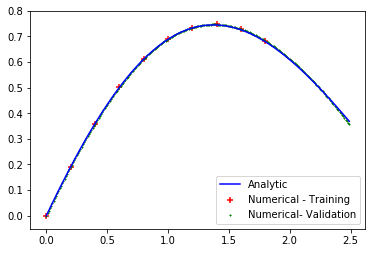

In [63]:
Ye3sol = np.array([example3_trial_solution.predict(Xe3[i]) for i in range(Xe3.shape[0])]).reshape((Xe3.shape[0],))
plt.scatter(Xe3.reshape((Xe3.shape[0],)), Ye3sol, c='r', label='Numerical - Training', marker='+', s=30)
Xe3plot = np.arange(0,2.5, 0.01)
Xe3plot = Xe3plot.reshape((Xe3plot.shape[0], 1, 1))
Ye3 = np.array([example3_trial_solution.predict(Xe3plot[i]) for i in range(Xe3plot.shape[0])]).reshape((Xe3plot.shape[0],))
Xe3plot = Xe3plot.reshape((Xe3plot.shape[0],))
Ye33 = np.array([np.exp(-0.2*Xe3plot[i]) * np.sin(Xe3plot[i]) for i in range(Xe3plot.shape[0])])
plt.scatter(Xe3plot, Ye3, c='g', label='Numerical- Validation', marker='x', s=1)
plt.plot(Xe3plot, Ye33, c='b', label='Analytic')
plt.legend()
plt.show()

In [64]:
print(example3_trial_solution.network.hidden_layer.bias.min())
print(example3_trial_solution.network.hidden_layer.bias.max())
print(example3_trial_solution.network.hidden_layer.weights.min())
print(example3_trial_solution.network.hidden_layer.weights.max())
print(example3_trial_solution.network.visible_layer.weights.min())
print(example3_trial_solution.network.visible_layer.weights.max())

-0.249782280967
0.1975131695
-1.20913020488
0.949159982561
-0.500278174392
0.490153757516


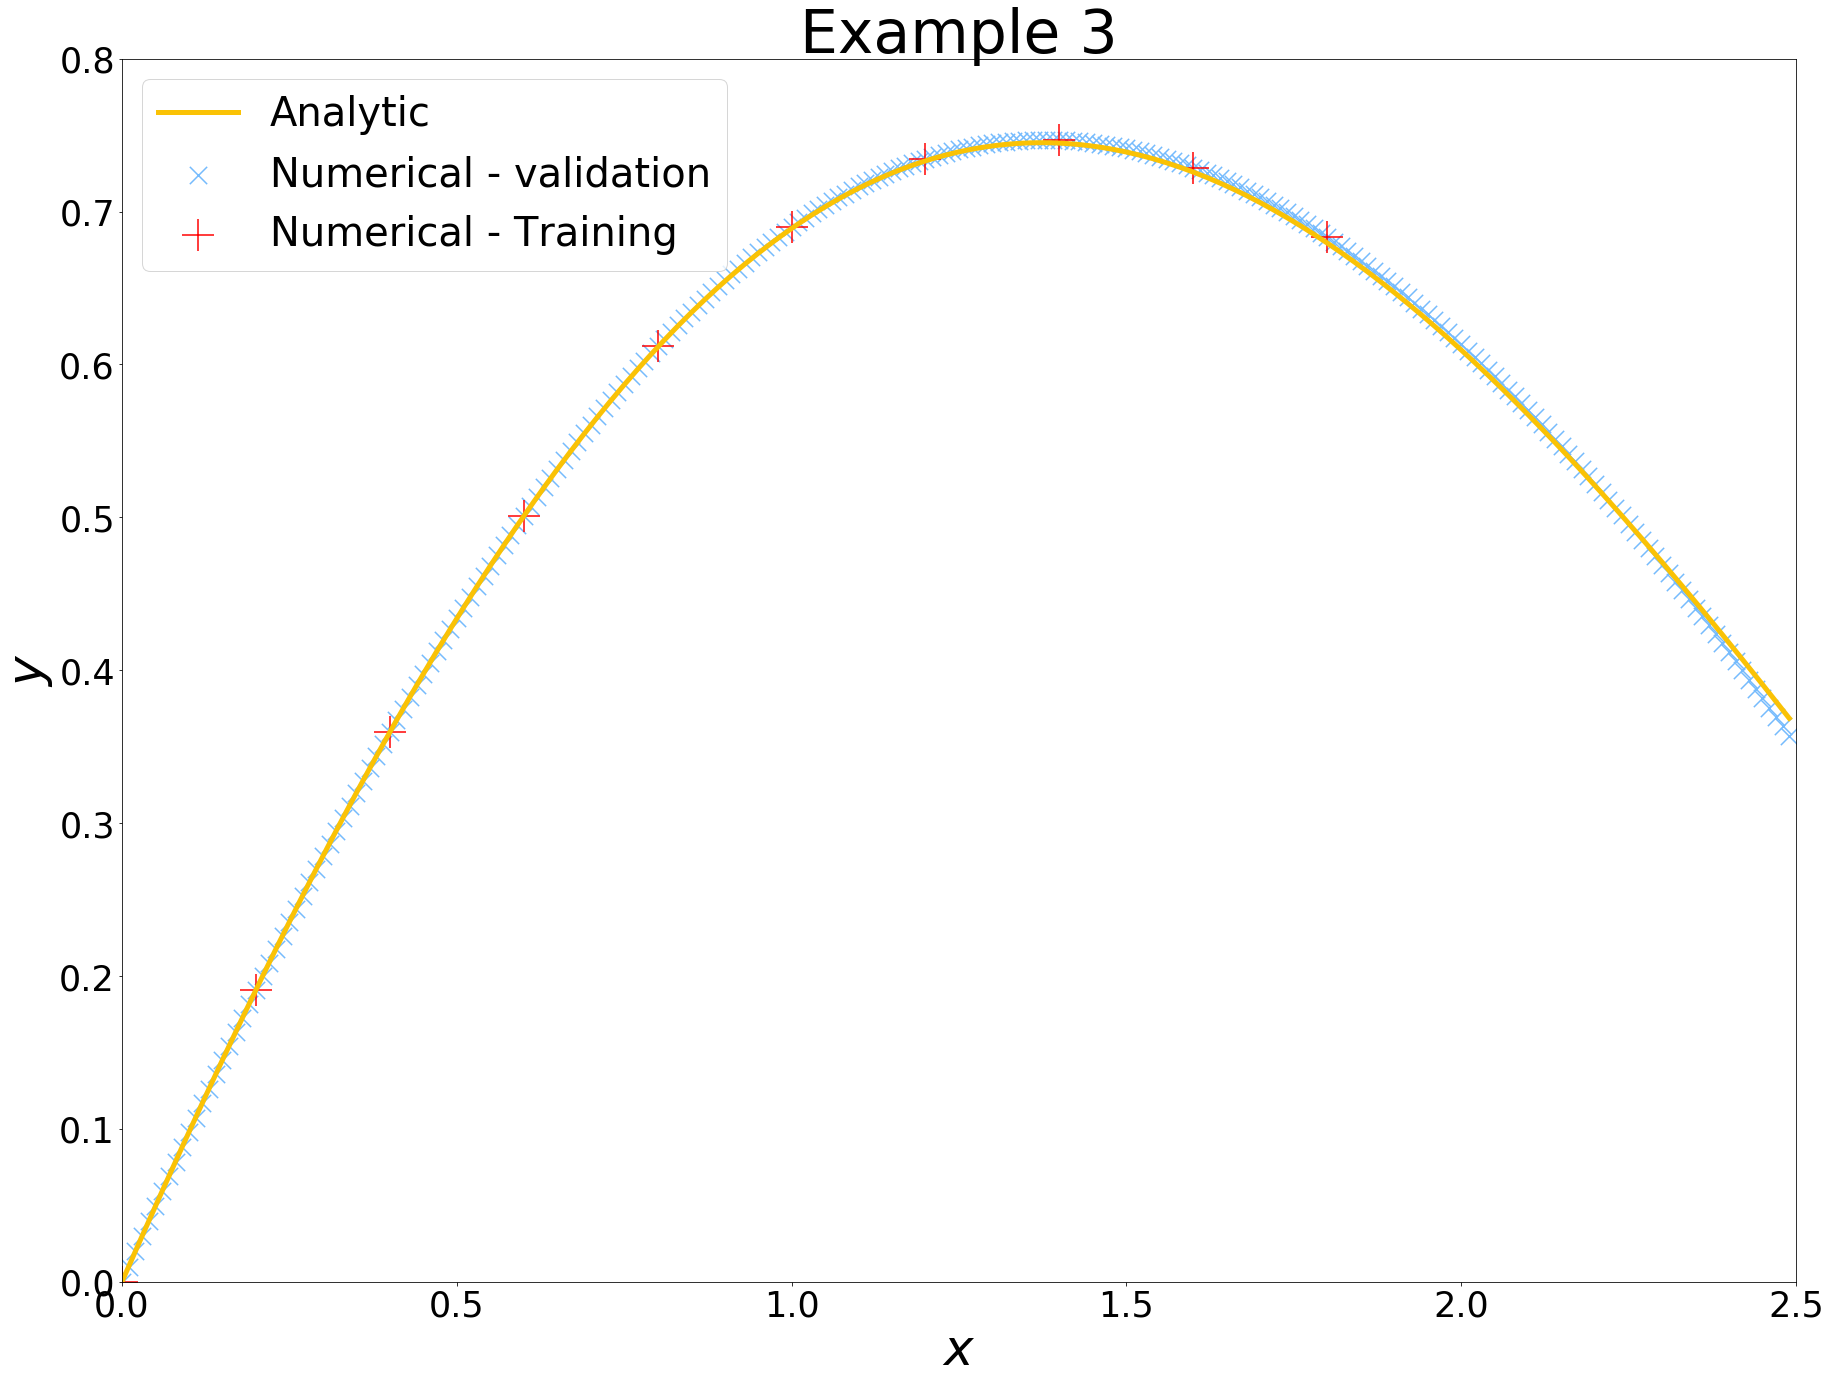

In [68]:
plt.clf()
plt.scatter(Xe3plot, Ye3, c='xkcd:sky blue', label='Numerical - validation', marker='x', s=300)
plt.scatter(Xe3.reshape((Xe3.shape[0],)), Ye3sol, c='r', label='Numerical - Training', marker='+', s=1000)
plt.plot(Xe3plot, Ye33, c='xkcd:goldenrod', label='Analytic', linewidth=5)
plt.xlabel(r'$x$', fontsize='50')
plt.ylabel(r'$y$', fontsize='50')
plt.xlim((0,2.5))
plt.ylim((0.,0.8))
# plt.axis('equal')
plt.legend(fontsize='40')
plt.title('Example 3', fontsize='60')
plt.gcf().set_size_inches(30, 22.5)
plt.tick_params(axis='both', which='major', labelsize=35)
plt.savefig('plots/example3.jpg')
plt.show()